In [16]:
import os

import numpy as np
import torch
from PIL import Image
from torch.utils import data

num_classes = 19
ignore_label = 255
root = '/srv/glusterfs/yardima/datasets/cityscape/'

palette = [128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156, 190, 153, 153, 153, 153, 153, 250, 170, 30,
           220, 220, 0, 107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60, 255, 0, 0, 0, 0, 142, 0, 0, 70,
           0, 60, 100, 0, 80, 100, 0, 0, 230, 119, 11, 32]
zero_pad = 256 * 3 - len(palette)
for i in range(zero_pad):
    palette.append(0)


def colorize_mask(mask):
    # mask: numpy array of the mask
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask


def make_dataset(quality, mode):
    assert (quality == 'fine' and mode in ['train', 'val']) or \
           (quality == 'coarse' and mode in ['train', 'train_extra', 'val'])

    if quality == 'coarse':
        img_dir_name = 'leftImg8bit_trainextra' if mode == 'train_extra' else 'leftImg8bit'
        mask_path = os.path.join(root, 'gtCoarse', 'gtCoarse', mode)
        mask_postfix = '_gtCoarse_labelIds.png'
        img_path = os.path.join(root, img_dir_name, 'leftImg8bit', mode)
    else:
        mask_path = os.path.join(root, 'gtFine', mode)
        mask_postfix = '_gtFine_labelIds.png'
        img_path = os.path.join(root, 'leftImg8bit', mode)
    assert os.listdir(img_path) == os.listdir(mask_path)
    items = []
    categories = os.listdir(img_path)
    for c in categories:
        c_items = [name.split('_leftImg8bit.png')[0] for name in os.listdir(os.path.join(img_path, c))]
        for it in c_items:
            item = (os.path.join(img_path, c, it + '_leftImg8bit.png'), os.path.join(mask_path, c, it + mask_postfix))
            items.append(item)
    return items


class CityScapes(data.Dataset):
    def __init__(self, quality, mode, joint_transform=None, sliding_crop=None, transform=None, target_transform=None):
        self.imgs = make_dataset(quality, mode)
        if len(self.imgs) == 0:
            raise RuntimeError('Found 0 images, please check the data set')
        self.quality = quality
        self.mode = mode
        self.joint_transform = joint_transform
        self.sliding_crop = sliding_crop
        self.transform = transform
        self.target_transform = target_transform
        self.id_to_trainid = {-1: ignore_label, 0: ignore_label, 1: ignore_label, 2: ignore_label,
                              3: ignore_label, 4: ignore_label, 5: ignore_label, 6: ignore_label,
                              7: 0, 8: 1, 9: ignore_label, 10: ignore_label, 11: 2, 12: 3, 13: 4,
                              14: ignore_label, 15: ignore_label, 16: ignore_label, 17: 5,
                              18: ignore_label, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14,
                              28: 15, 29: ignore_label, 30: ignore_label, 31: 16, 32: 17, 33: 18}

    def __getitem__(self, index):
        img_path, mask_path = self.imgs[index]
        img, mask = Image.open(img_path).convert('RGB'), Image.open(mask_path)

        mask = np.array(mask)
        mask_copy = mask.copy()
        for k, v in self.id_to_trainid.items():
            mask_copy[mask == k] = v
        mask = Image.fromarray(mask_copy.astype(np.uint8))

        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        if self.sliding_crop is not None:
            img_slices, mask_slices, slices_info = self.sliding_crop(img, mask)
            if self.transform is not None:
                img_slices = [self.transform(e) for e in img_slices]
            if self.target_transform is not None:
                mask_slices = [self.target_transform(e) for e in mask_slices]
            img, mask = torch.stack(img_slices, 0), torch.stack(mask_slices, 0)
            return img, mask, torch.LongTensor(slices_info)
        else:
            if self.transform is not None:
                img = self.transform(img)
            if self.target_transform is not None:
                mask = self.target_transform(mask)
            return img, mask

    def __len__(self):
        return len(self.imgs)

In [18]:
dataset = CityScapes("fine", "train")

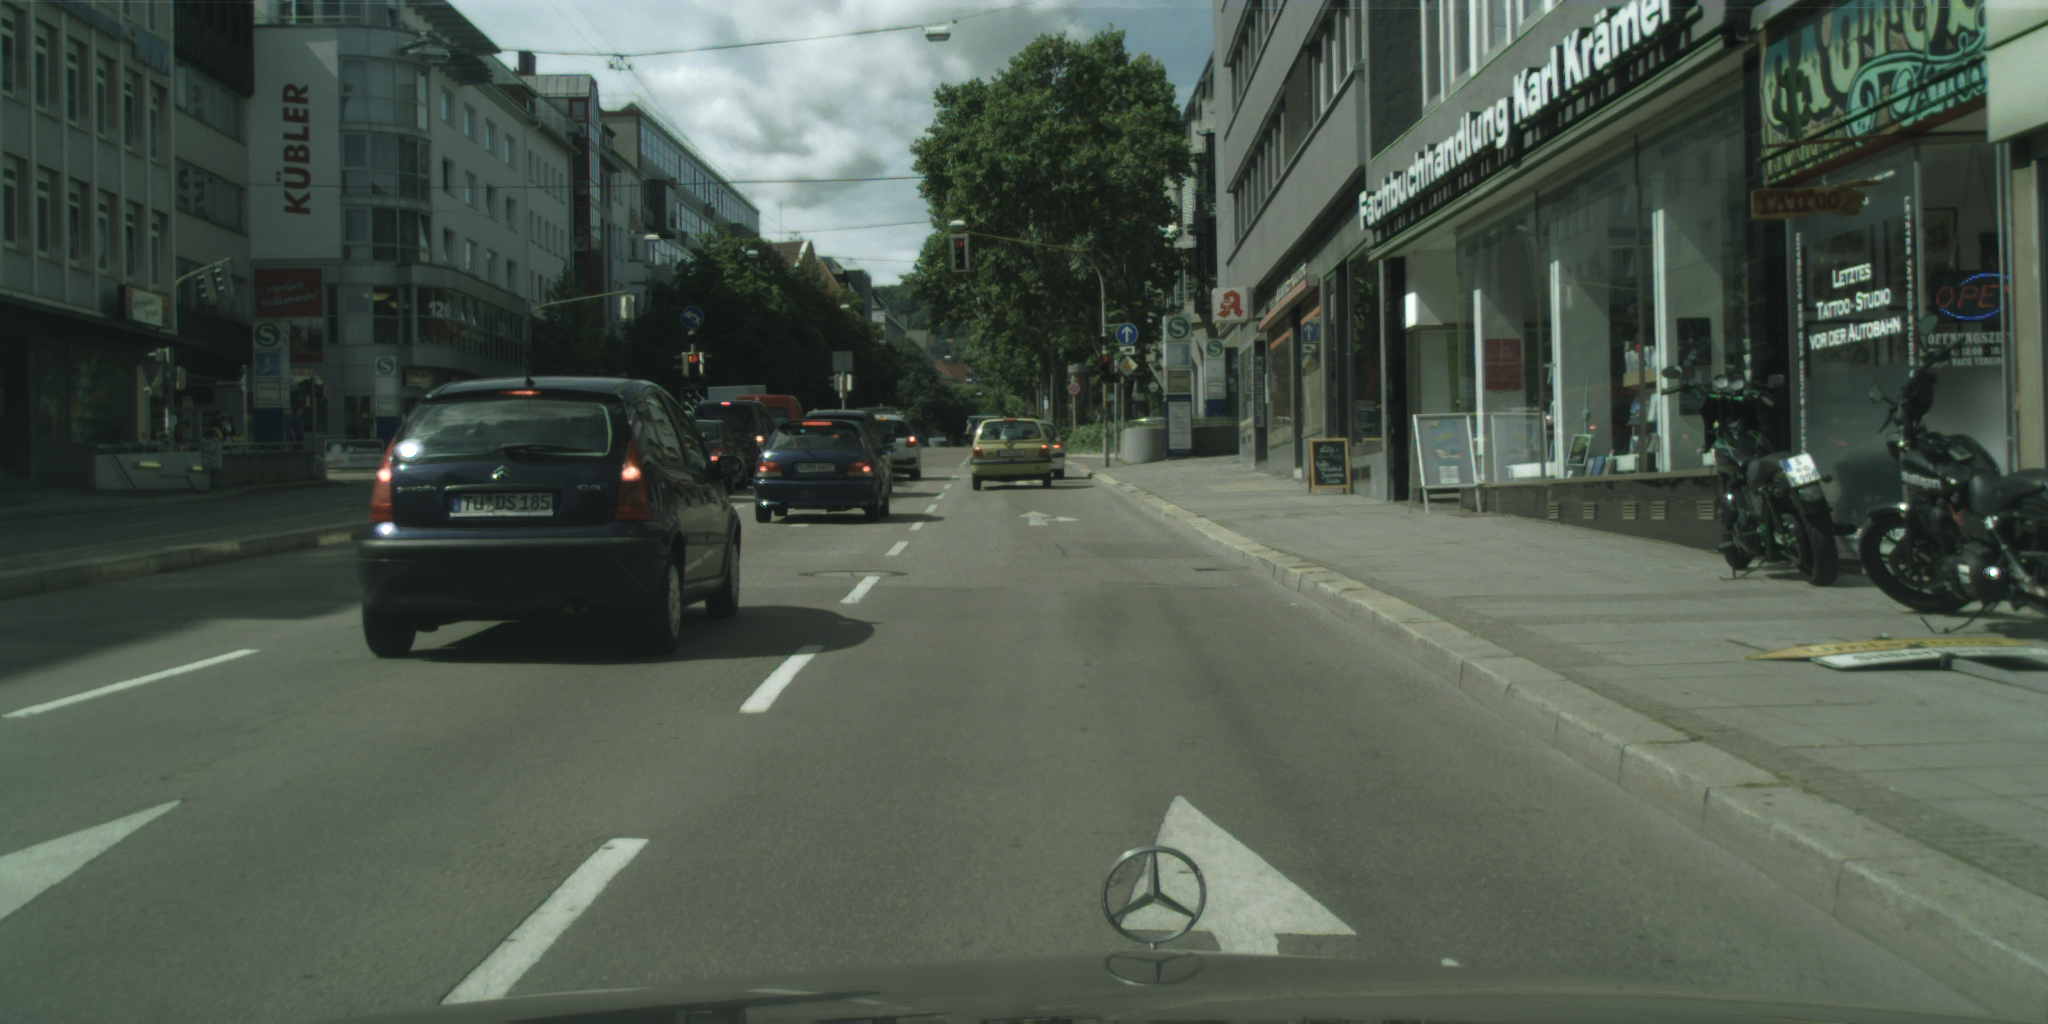

In [28]:
dataset[1][0]

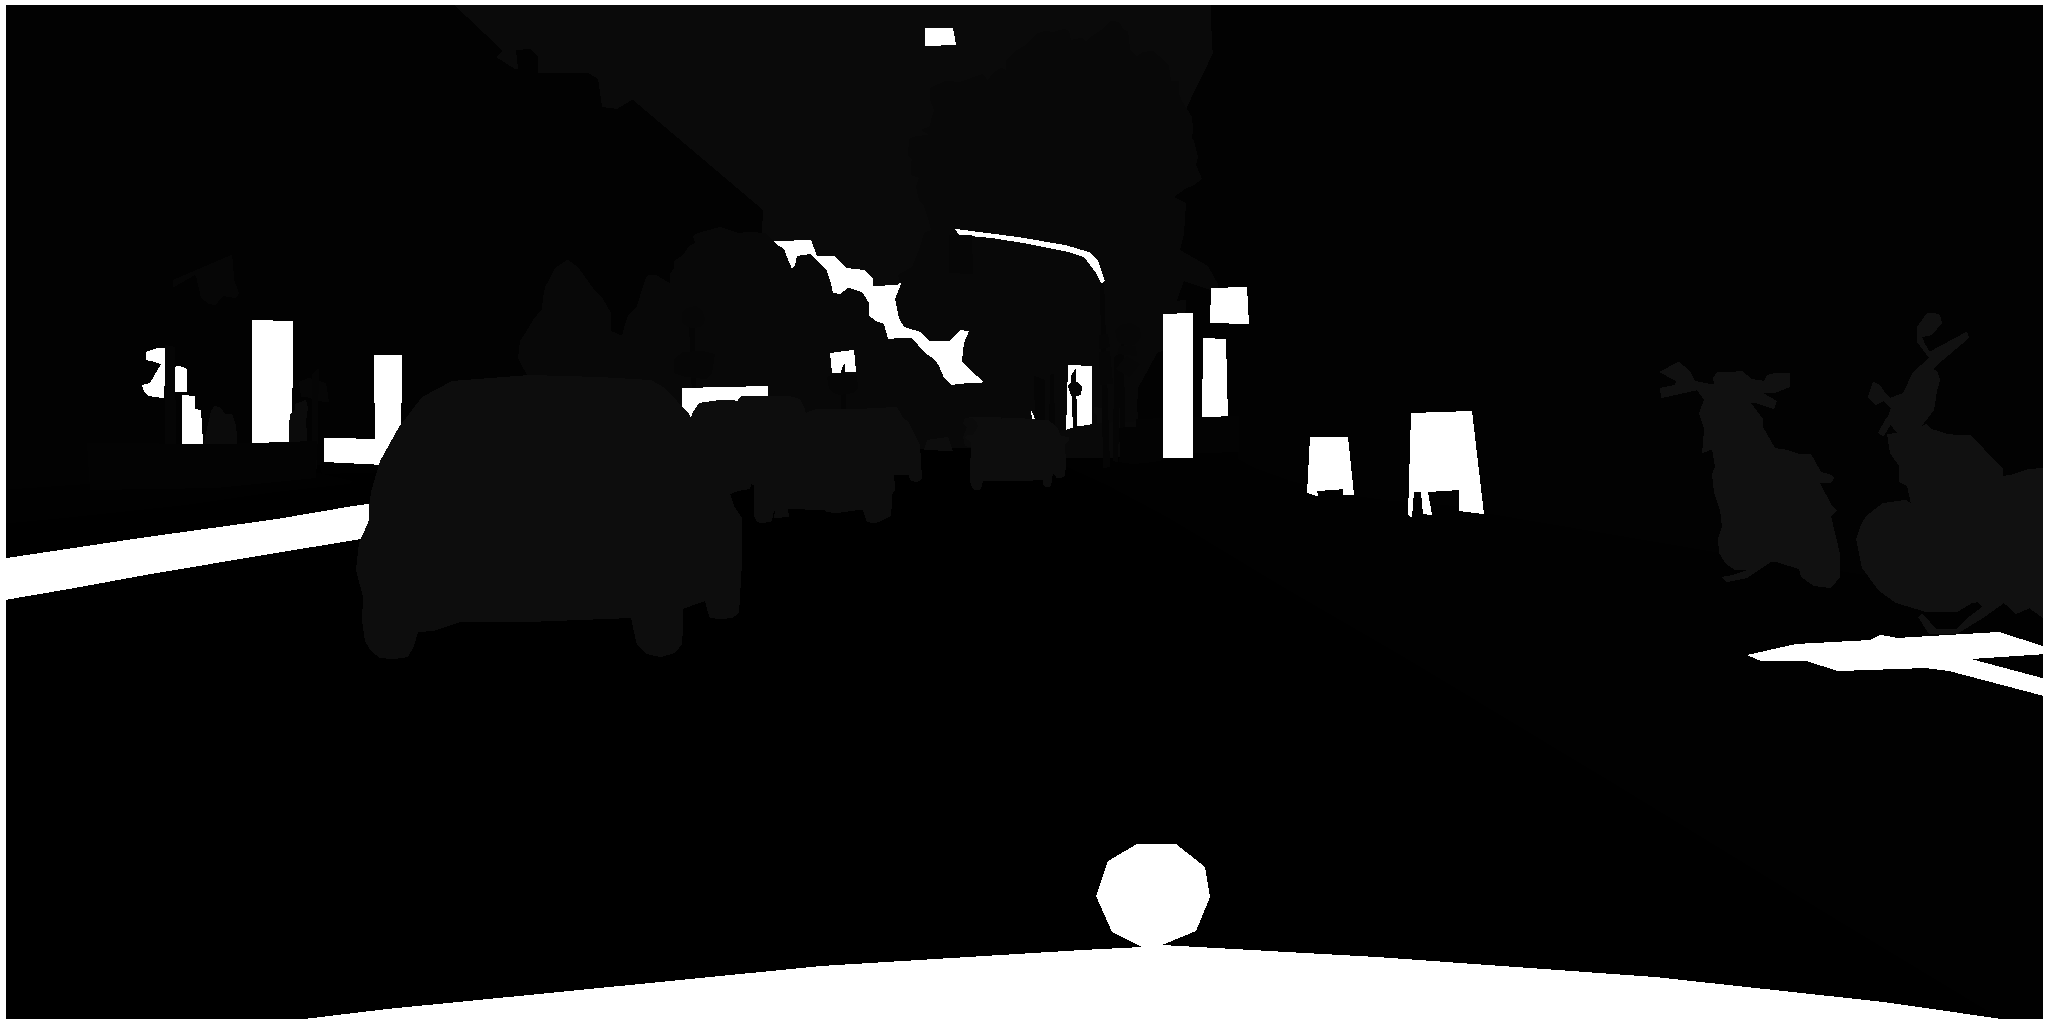

In [21]:
dataset[1][1]

In [24]:
print(len(dataset))

2975


In [26]:
import matplotlib.pyplot as plt

(array([1926308.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  170844.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

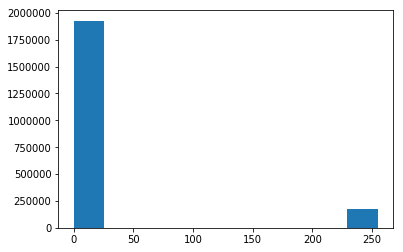

In [27]:
a = np.array(dataset[1][1])
plt.hist(a.reshape(-1))